In [138]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from matplotlib import colors
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display, HTML, Markdown
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("/content/drive/MyDrive")

In [4]:
#importing the dataset
df=pd.read_csv("/content/drive/MyDrive/train.csv")
df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [5]:

#check that dataset datatypes and check nulls 
#your code here
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='NA'
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)

tbl_report(df)

Table Shape (76020, 371)


,dtype,nulls,uniques,num_uniques,value_counts
ID,int64,0,"[1, 3, 4, 8, 10, 13, 14, 18, 20, 23, 25, 26, 29, 31, 32, 34, 36, 39, 42, 43, 45, 49, 51, 54, 56, 60, 61, 66, 68, 74, 75, 77, 80, 82, 83, 84, 87, 88, 90, 91, 92, 93, 95, 101, 102, 105, 106, 107, 109, 111, 113, 115, 118, 122, 125, 127, 130, 131, 132, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 148, 150, 151, 152, 153, 154, 155, 156, 157, 159, 161, 162, 163, 165, 166, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 182, 183, 184, ...]",76020,NA
var3,int64,0,"[2, 229, 178, 0, 8, 3, 4, 10, 110, 7, 177, 1, 6, 137, 17, -999999, 13, 14, 148, 5, 11, 15, 122, 22, 9, 58, 121, 12, 127, 33, 125, 209, 72, 31, 51, 16, 107, 174, 141, 191, 104, 129, 18, 49, 73, 94, 131, 219, 187, 114, 28, 89, 115, 53, 126, 47, 84, 235, 161, 197, 23, 30, 146, 158, 138, 26, 120, 66, 216, 215, 90, 20, 21, 103, 192, 142, 29, 163, 223, 95, 98, 38, 156, 97, 105, 150, 183, 184, 52, 54, 220, 25, 225, 86, 124, 27, 162, 19, 195, 218, ...]",208,NA
var15,int64,0,"[23, 34, 37, 39, 27, 26, 45, 25, 42, 51, 43, 33, 30, 44, 36, 55, 28, 35, 54, 40, 24, 14, 66, 50, 22, 62, 60, 64, 76, 31, 38, 41, 56, 72, 68, 5, 77, 29, 63, 32, 57, 80, 52, 61, 71, 88, 59, 53, 100, 74, 86, 73, 48, 46, 49, 65, 47, 21, 75, 58, 67, 13, 83, 87, 84, 70, 78, 85, 17, 94, 79, 89, 81, 15, 69, 11, 90, 102, 91, 10, 92, 82, 18, 12, 19, 7, 93, 9, 96, 6, 8, 16, 95, 97, 98, 20, 99, 105, 104, 101]",100,NA
imp_ent_var16_ult1,float64,0,"[0.0, 600.0, 525.0, 3000.0, 24.0, 30.0, 450.0, 120.0, 3.0, 300.0, 63.0, 750.0, 60.0, 90.0, 195.0, 1950.0, 240.0, 852.0, 294.0, 900.0, 270.0, 150.0, 9000.0, 540.66, 154.5, 1.5, 15.0, 45.0, 180.0, 810.0, 660.0, 870.0, 5310.0, 510.0, 2400.0, 390.0, 1350.0, 246.69, 4500.0, 10937.52, 6.0, 1500.0, 735.0, 5400.0, 330.0, 360.0, 480.0, 2250.0, 630.0, 1080.0, 855.0, 1905.0, 540.0, 550.5, 26022.51, 336.0, 4200.0, 570.0, 249.57, 1890.0, 1200.0, 1020.0, 210.0, 2670.0, 2397.0, 9.0, 799.5, 216.0, 1260.0, 4950.0, 12000.0, 1800.0, 1368.0, 315.0, 27.0, 2685.0, 6000.0, 2310.0, 8100.0, 322.89, 81.0, 1650.0, 586.5, 675.0, 6969.0, 2700.0, 3555.0, 1860.0, 2100.0, 4947.39, 75.0, 39000.0, 135.0, 2370.0, 290.97, 30.03, 15000.0, 3600.0, 816.6, 3480.0, ...]",596,NA
imp_op_var39_comer_ult1,float64,0,"[0.0, 195.0, 1086.48, 55.2, 117.75, 1658.37, 55.05, 59.7, 59.1, 477.06, 353.97, 808.95, 26.97, 25.2, 1693.56, 2142.78, 828.18, 534.0, 224.43, 97.59, 836.34, 11.4, 229.5, 759.18, 15.0, 830.01, 8.19, 100.56, 259.35, 756.81, 1267.56, 817.89, 246.36, 102.0, 90.0, 2.67, 579.57, 13.8, 10.32, 572.19, 74.55, 101.94, 20.25, 152.58, 369.45, 665.07, 1200.45, 632.88, 126.42, 813.63, 319.17, 599.76, 4765.89, 440.07, 58.44, 1424.79, 5457.51, 57.6, 8.91, 53.25, 681.84, 3579.72, 304.74, 57.0, 318.12, 24.54, 152.19, 597.06, 36.9, 486.12, 161.7, 634.86, 456.93, 765.66, 224.07, 66.0, 117.15, 482.46, 126.87, 531.84, 269.46, 40.44, 66.96, 762.75, 318.9, 115.5, 42.0, 492.63, 2649.48, 203.07, 46.83, 2338.95, 89.94, 30.0, 213.09, 870.75, 1525.89, 1509.0, 860.31, 486.27, ...]",7551,NA
imp_op_var39_comer_ult3,float64,0,"[0.0, 195.0, 1952.91, 70.95, 122.25, 5722.77, 127.44, 59.7, 59.1, 618.36, 390.81, 1132.98, 184.47, 25.2, 126.6, 2017.92, 3444.42, 2320.65, 534.0, 391.56, 97.59, 1969.35, 11.4, 268.5, 759.18, 15.0, 2002.26, 8.19, 33.45, 100.56, 354.0, 259.35, 1298.46, 3468.36, 842.13, 246.36, 299.4, 90.0, 2111.91, 291.0, 3253.71, 13.8, 28.83, 632.04, 505.29, 71.43, 4585.8, 528.21, 20.25, 491.64, 369.45, 877.47, 181.89, 1698.42, 244.17, 919.92, 234.51, 281.94, 1928.07, 640.02, 911.58, 10966.5, 628.17, 58.44, 135.0, 2457.96, 9031.74, 57.6, 13.68, 53.25, 681.84, 4018.17, 541.89, 57.0, 340.62, 24.54, 152.19, 597.06, 36.0, 36.9, 486.12, 161.7, 634.86, 456.93, 765.66, 1958.55, 66.0, 117.15, 11.01, 482.46, 46.2, 168.0, 173.67, 531.84, 40.44, 66.96, 1569.69, 318.9, 224.43, 42.0, ...]",9099,NA
imp_op_var40_comer_ult1,float64,0,"[0.0, 247.56, 828.18, 746.1, 383.85, 224.07, 2061.45, 401.4, 75.12, 721.5, 289.59, 4061.28, 188.88, 587.43, 323.76, 4443.03, 428.1, 7904.22, 4625.

There is no null values in the data set but there are large numbers like -999999 which might indicate the null values. Certain features have 0 variance by having only one value for all the samples.

In [6]:
# drop ID and target label from X
X=df.drop(['ID','TARGET'],axis=1)
X.head()
#defining target
y = df['TARGET']

## Splitting the data

In [7]:
x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=10,stratify=y)

## EDA cum Data Preprocessing

In [8]:
# for total number of features
X.columns.shape

(369,)

The no. of customers that are unsatisfied are 3008.
The no. of customers that are satisfied are 73012.



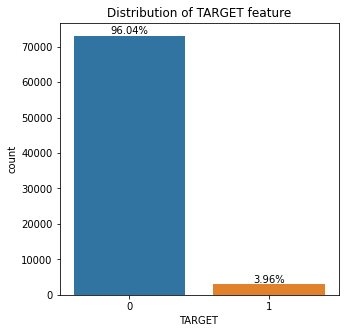

In [9]:
def countplot_target(df,h=500,size=(5,5)):
    plt.figure(figsize=size)
    ax = sns.countplot(x='TARGET',data=df)
    total = df.shape[0]
    #https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + h,
                '{:1.2f}%'.format(height*100/total),
                ha="center") 
    plt.title("Distribution of TARGET feature")
    target_1 = df[df['TARGET']==1].shape[0]
    target_0 = df[df['TARGET']==0].shape[0]
    print("The no. of customers that are unsatisfied are %i."%(target_1))
    print("The no. of customers that are satisfied are %i."%(target_0))
    print('')
    plt.show()
countplot_target(df)

There seems to be a greater imbalance in the dataset as the number of customers satisfied are very much less compared to the number of customers satisfied.

In [10]:
#counting number of -999999
x_train['var3'].value_counts()

 2         59308
 8           110
 9            93
 3            87
-999999       83
           ...  
 87            1
 41            1
 182           1
 169           1
 223           1
Name: var3, Length: 195, dtype: int64

Replacing -999999 with 2 because 2 is the mostly found value in this feature.

In [11]:
x_train['var3'] = x_train['var3'].replace(-999999, 2)
x_test['var3'] = x_test['var3'].replace(-999999, 2)
x_train['var3'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2      59391
8        110
9         93
3         87
7         81
       ...  
87         1
41         1
182        1
169        1
223        1
Name: var3, Length: 194, dtype: int64

From the table report developed above we found that most of the features have nearly zero varaiance. Hence removing the features with nearly zero varaince.

In [12]:
#using sklearn variancethreshold to find constant features
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(x_train) 

VarianceThreshold(threshold=0)

In [13]:
# get_support is a boolean vector that indicates which features are retained
# if we sum over get_support, we get the number of features that are not constant
sum(sel.get_support())

334

In [14]:
#dropping constant columns
x_train = x_train[x_train.columns[sel.get_support()]]
x_test=x_test[x_test.columns[sel.get_support()]]
x_train.shape

(60816, 334)

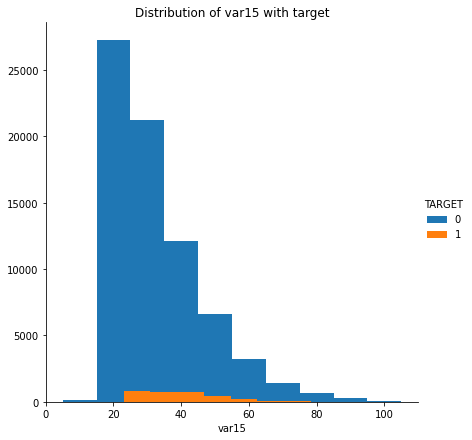

The minimum age of the unsatisfied customer is 5 and maximum age of the unsatisfied customer is 105 .


In [15]:
#plotting the distribution of var15 with target
sns.FacetGrid(data=df,hue='TARGET',height=6).map(plt.hist,'var15').add_legend()
plt.title("Distribution of var15 with target")
plt.show()

max_ = df['var15'].max()
min_ = df['var15'].min()
print("The minimum age of the unsatisfied customer is %i and maximum age of the unsatisfied customer is %i ."%(min_,max_ ))

In [16]:
#extracting keywords in features and ignoring 'var15_below_23'
f_keywords = {col.split('_')[0] for col in x_train.columns if (len(col.split('_'))>1) & ~('var15' in col)} 
f_keywords

{'delta', 'imp', 'ind', 'num', 'saldo'}

In [17]:
#counting the number of each keyword features
f_keywords = dict(zip(f_keywords,np.zeros(len(f_keywords),dtype=int)))
for key in f_keywords.keys():
    for col in x_train.columns:
        if key in col:
            f_keywords[key]+=1
f_keywords

{'delta': 26, 'imp': 57, 'ind': 66, 'num': 142, 'saldo': 64}

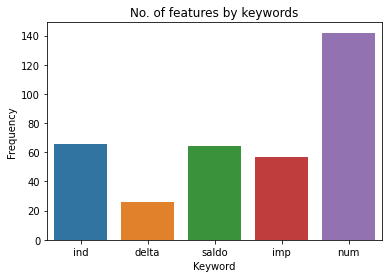

In [18]:
k = pd.Series(f_keywords)
sns.barplot(x=k.index,y=k.values)
plt.title("No. of features by keywords")
plt.ylabel('Frequency')
plt.xlabel('Keyword')
plt.show()

We can see that no. of features with 'num' keyword is the highest while 'delta' had smaller representation.

Finding highly correlated features

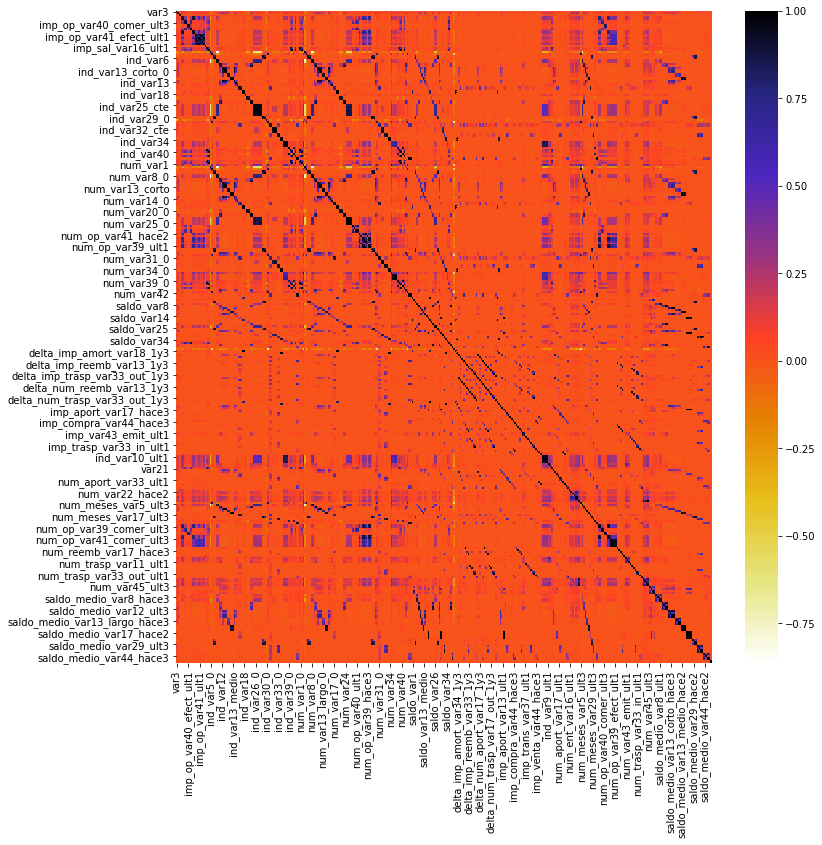

In [19]:
#Using Pearson Correlation
corrmat = x_train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(12,12)
sns.heatmap(corrmat,cmap="CMRmap_r")

From the correlation plot, we can infer that there is correlation between lot of features especially with neighbour features

In [20]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [21]:
corr_features = correlation(x_train, 0.98)
len(set(corr_features))

107

In [22]:
#removing correlated features
x_train = x_train.drop(corr_features,axis=1)
x_test = x_test.drop(corr_features,axis=1)

In [23]:
#Feature Scaling
scaler = MinMaxScaler().fit(x_train)

x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns = x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)


In [24]:
# adding new features from PCA's 2 components
from sklearn.decomposition import PCA
dec=PCA(n_components=2).fit(x_train_scaled)
x_test_scaled[['p_1','p_2']]=dec.transform(x_test_scaled)
x_train_scaled[['p_1','p_2']]=dec.transform(x_train_scaled)

## Modeling

### Baseline model - Logistic Regression

In [25]:
# Dataimbalace handling based on class_weights
logreg_1 = LogisticRegression(C=0.001,penalty='l2',class_weight='balanced')
logreg_1.fit(x_train_scaled, y_train)
y_pred_log_1 = logreg_1.predict(x_test_scaled)

print('Logistic Regression fitted with balanced class weight accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred_log_1)))

Logistic Regression fitted with balanced class weight accuracy score : 0.7087


In [26]:
# F1 score for logistic regression model fitted by class_weight
f1_lr_1=f1_score(y_test, y_pred_log_1, average='macro')
print(f1_lr_1)

0.48589306118606723


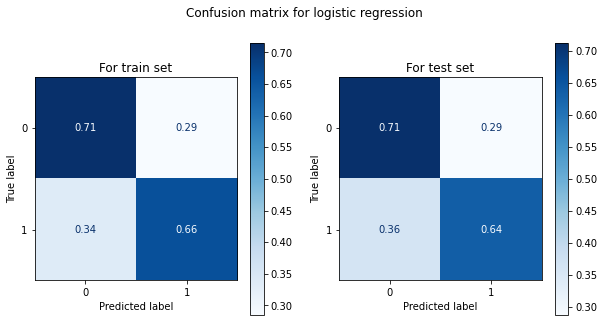

In [89]:
# plotting confusion matrix
fig,ax=plt.subplots(1,2,figsize=(10,5))
plt.suptitle('Confusion matrix for logistic regression')
cm=confusion_matrix(y_train, logreg_1.predict(x_train_scaled), labels=logreg_1.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg_1.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax[0])
ax[0].set_title('For train set')

cm=confusion_matrix(y_test, y_pred_log_1, labels=logreg_1.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg_1.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax[1])
ax[1].set_title('For test set');

In [83]:
# creating dataframe to store the metric values for each classifiers
f1_df=pd.DataFrame()
accuracy_df=pd.DataFrame()
auc_df=pd.DataFrame()
f1_df['LR_model']=[f1_lr_1]
accuracy_df['LR_model']=[accuracy_score(y_test, y_pred_log_1)]
auc_df['LR_model']=[roc_auc_score(y_test,logreg_1.predict_proba(x_test_scaled)[:,1])]

Data imbalance was handled using by giving more weights to the lowest class in the data


### Desicion Tree model

In [28]:
# using class_weight
DecisionTree_1=DecisionTreeClassifier(random_state=42,class_weight='balanced').fit(x_train_scaled,y_train)


In [29]:
y_pred_DT_1=DecisionTree_1.predict(x_test_scaled)

In [30]:
print('Decision Tree (class_weight) accuracy score for test: {0:0.4f}'. format(accuracy_score(y_test, y_pred_DT_1)))

Decision Tree (class_weight) accuracy score for test: 0.9173


In [31]:
print('Decision Tree (class_weight) f1 score for test: {0:0.4f}'. format(f1_score(y_test, y_pred_DT_1, average='macro')))

Decision Tree (class_weight) f1 score for test: 0.5562


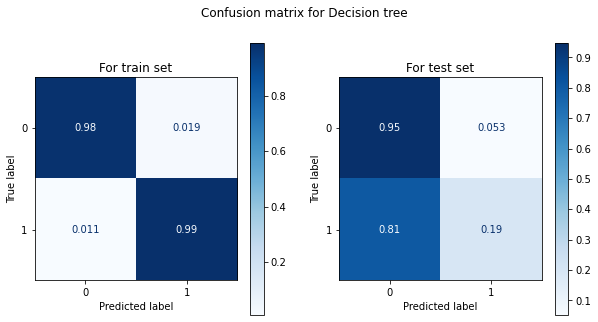

In [54]:
# plotting confusion matrix
fig,ax=plt.subplots(1,2,figsize=(10,5))
plt.suptitle('Confusion matrix for Decision tree')
cm=confusion_matrix(y_train, DecisionTree_1.predict(x_train_scaled), labels=logreg_1.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg_1.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax[0])
ax[0].set_title('For train set')

cm=confusion_matrix(y_test, DecisionTree_1.predict(x_test_scaled), labels=logreg_1.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg_1.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax[1])
ax[1].set_title('For test set');

In [84]:
f1_df['Dtree_model']=[f1_score(y_test, y_pred_DT_1, average='macro')]
accuracy_df['Dtree_model']=[accuracy_score(y_test, y_pred_DT_1)]
auc_df['Dtree_model']=[roc_auc_score(y_test,DecisionTree_1.predict_proba(x_test_scaled)[:,1])]

## Ensemble Models

### Random Forest classifier

In [33]:
# fitted with different class weights
RF_model_1=RandomForestClassifier(n_estimators=2000,
                       n_jobs=-1,class_weight='balanced').fit(x_train_scaled,y_train)

In [47]:
y_pred_rf_1=RF_model_1.predict(x_test_scaled)

In [48]:
print('Random forest accuracy score for test (class_weight): {0:0.4f}'. format(accuracy_score(y_test, y_pred_rf_1)))

Random forest accuracy score for test (class_weight): 0.9359


In [49]:
print('Random forest f1 score for test (class_weight): {0:0.4f}'. format(f1_score(y_test, y_pred_rf_1, average='macro')))

Random forest f1 score for test (class_weight): 0.5553


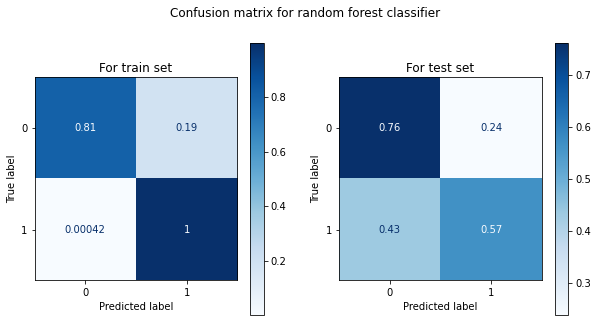

In [46]:
# plotting confusion matrix
fig,ax=plt.subplots(1,2,figsize=(10,5))
plt.suptitle('Confusion matrix for random forest classifier')
cm=confusion_matrix(y_train, RF_model_1.predict_proba(x_train_scaled)[:,1]>0.1, labels=RF_model_1.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg_1.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax[0])
ax[0].set_title('For train set')

cm=confusion_matrix(y_test, RF_model_1.predict_proba(x_test_scaled)[:,1]>0.1, labels=RF_model_1.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg_1.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax[1])
ax[1].set_title('For test set');

In [85]:
f1_df['RF_model']=[f1_score(y_test, y_pred_rf_1, average='macro')]
accuracy_df['RF_model']=[accuracy_score(y_test, y_pred_rf_1)]
auc_df['RF_model']=[roc_auc_score(y_test,RF_model_1.predict_proba(x_test_scaled)[:,1])]

### Boosting Classifier

In [50]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000,
                      reg_alpha = 0.2,
                      max_depth=6, 
                      gamma=0, random_state=42
                     )

In [51]:
clf_xgb.fit(x_train_scaled,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [52]:
y_pred_xgb=clf_xgb.predict(x_test_scaled)

In [53]:
print('XBoost accuracy score for test: {0:0.4f}'. format(accuracy_score(y_test, y_pred_xgb)))

XBoost accuracy score for test: 0.9605


In [56]:
f1_XB=f1_score(y_test, y_pred_xgb,average='macro')
print(f1_XB)

0.49651183327446136


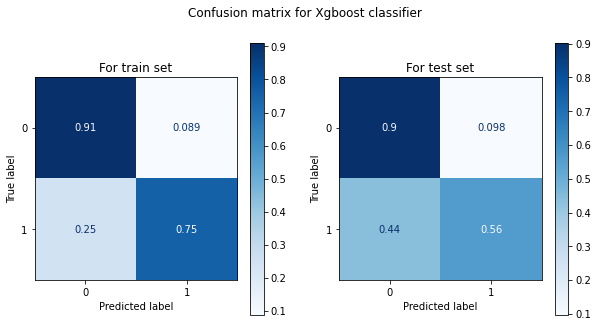

In [55]:
# plotting confusion matrix
fig,ax=plt.subplots(1,2,figsize=(10,5))
plt.suptitle('Confusion matrix for Xgboost classifier')
cm=confusion_matrix(y_train, clf_xgb.predict_proba(x_train_scaled)[:,1]>0.1, labels=clf_xgb.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_xgb.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax[0])
ax[0].set_title('For train set')

cm=confusion_matrix(y_test, clf_xgb.predict_proba(x_test_scaled)[:,1]>0.1, labels=clf_xgb.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_xgb.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax[1])
ax[1].set_title('For test set');

In [86]:
f1_df['Xg_model']=[f1_score(y_test, y_pred_xgb, average='macro')]
accuracy_df['Xg_model']=[accuracy_score(y_test, y_pred_xgb)]
auc_df['Xg_model']=[roc_auc_score(y_test,clf_xgb.predict_proba(x_test_scaled)[:,1])]

## Model performance evaluation

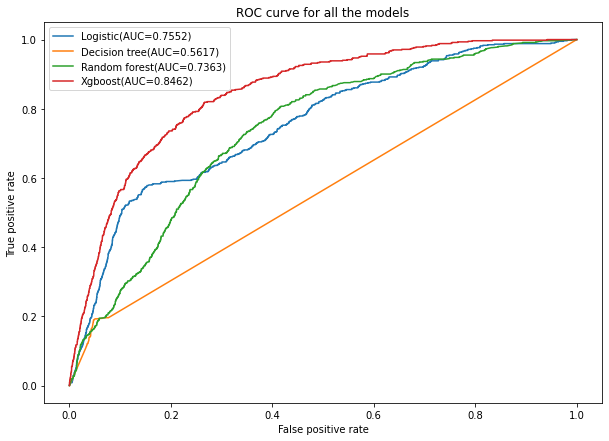

In [104]:
# plotting roc_auc curve foe all the developed models
fig,ax=plt.subplots(figsize=(10,7))
models=[logreg_1,DecisionTree_1,RF_model_1,clf_xgb]
estimators=['Logistic','Decision tree','Random forest','Xgboost']
for model,name in zip(models,estimators):
  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test_scaled)[:,1])
  roc_auc = round(roc_auc_score(y_test, model.predict_proba(x_test_scaled)[:,1]),4)
  ax.plot(fpr, tpr, label=name+'(AUC='+str(roc_auc)+')')
ax.set(xlabel='False positive rate',ylabel='True positive rate',title='ROC curve for all the models')
plt.legend()

Xg boost has the maximum auc scorecompared to the other models. Random forest and logistic regression models ahve almost same auc score. decision tree calssifier has lowest auc score because it does not predict probabilities.

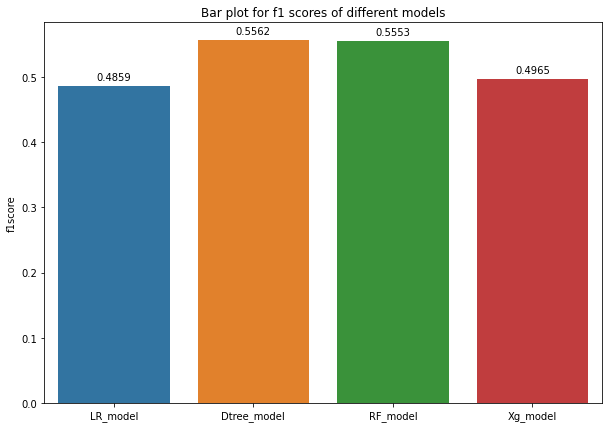

In [114]:
# plotting f1 scores
fig,ax=plt.subplots(figsize=(10,7))
sns.barplot(x=f1_df.columns, y=f1_df.T[0],ax=ax)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax.set(ylabel='f1score',title='Bar plot for f1 scores of different models');

Decision tree and random forest model seems to have maximum f1 score compared to the other models

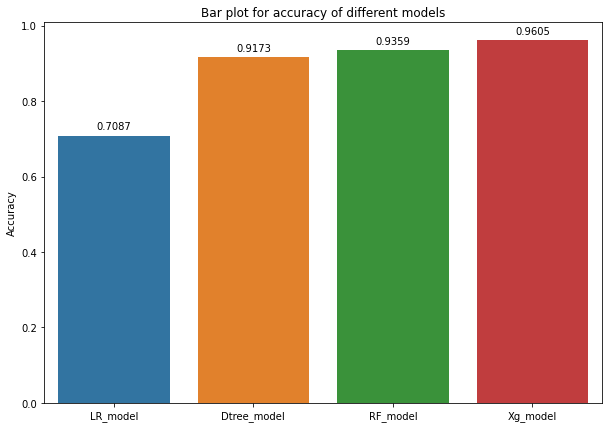

In [115]:
# plotting accuracy scores
fig,ax=plt.subplots(figsize=(10,7))
sns.barplot(x=accuracy_df.columns, y=accuracy_df.T[0],ax=ax)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax.set(ylabel='Accuracy',title='Bar plot for accuracy of different models');

Xg boost has the maximum accuracy while logistic regression model has the lowest accuracy

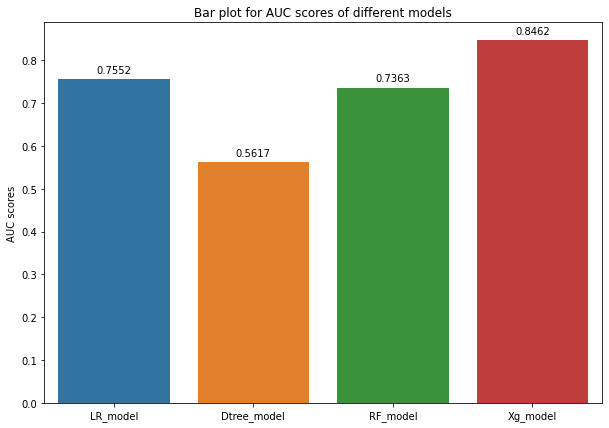

In [116]:
# plotting auc scores
fig,ax=plt.subplots(figsize=(10,7))
sns.barplot(x=auc_df.columns, y=auc_df.T[0],ax=ax)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax.set(ylabel='AUC scores',title='Bar plot for AUC scores of different models');

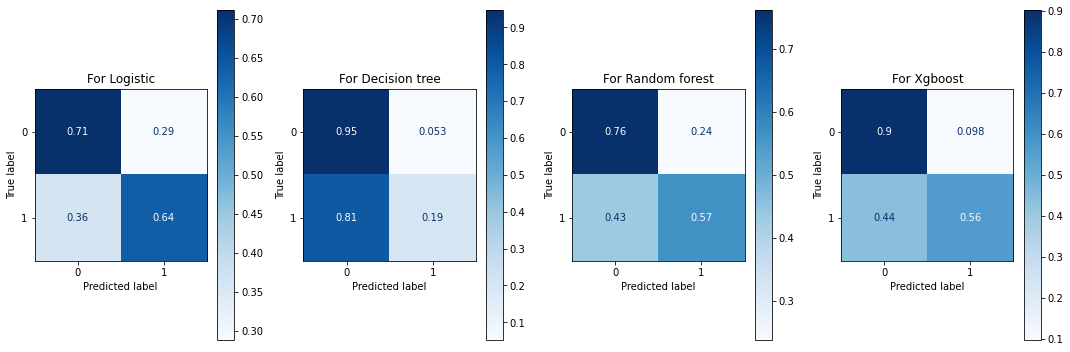

In [119]:
#confusion matrices for the models
thresholds=[0.5,0.5,0.1,0.1]
fig,axs=plt.subplots(1,4,figsize=(15,5))
axs=axs.flatten()
for model,name,ax,th in zip(models,estimators,axs,thresholds):
  cm=confusion_matrix(y_test, model.predict_proba(x_test_scaled)[:,1]>th, labels=model.classes_,normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
  disp.plot(cmap=plt.cm.Blues,ax=ax)
  ax.set_title('For '+name);
plt.tight_layout()

In [ ]:
# permutation importance for xgboost
result1=permutation_importance(clf_xgb, x_test_scaled, y_test,random_state=81,n_repeats=2,n_jobs=-1)

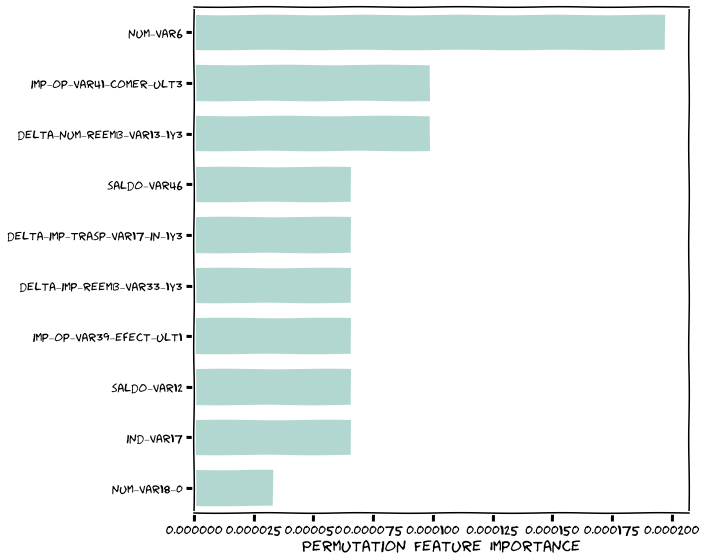

In [136]:
fig,ax1=plt.subplots(figsize=(10,8))
plt.xkcd(scale=0.3,randomness=0.6)
tree_importance_sorted_idx = np.argsort(result1.importances_mean)[-10:]
tree_indices = np.arange(0, len(result1.importances_mean[:10])) +0.5
ax1.barh(tree_indices, result1.importances_mean[tree_importance_sorted_idx], 
              height=0.7, color='#B2D7D0')
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx], fontsize=12)
ax1.set_ylim((0, len(result1.importances_mean[:10])))
ax1.set_xlabel("Permutation Feature Importance", fontsize=16)
fig.tight_layout()
plt.show()

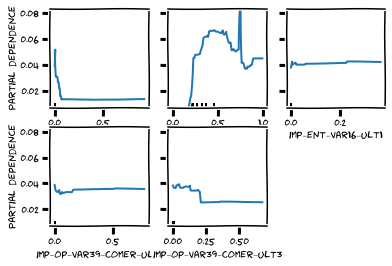

In [142]:
# partial dependence plot for xgboost classifier for first 10 features
features = [0, 1, 2,3,4]
plot_partial_dependence(clf_xgb, x_test_scaled, features,percentiles=(0, 1))

The first 5 features have almost non-linear relation with the target variable